In [1]:
import sys
sys.path.insert(0, '..')
import numpy as np
import pandas as pd 
from sklearn.model_selection import train_test_split
import pytorch_lightning as pl
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from cdw_cross_entropy_loss import CDW_CELoss
from torchmetrics.classification import MulticlassCohenKappa
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from glob import glob

# Data
We are going to work with the [US Census Data](https://github.com/ayrna/orca?tab=readme-ov-file). You can find a preprocessed version in `data/census`.

In [24]:
class CensusDataset(Dataset):
    def __init__(self, root_dir,
                 transform=None, 
                 target_transform=None, subsample: int = None):
        
        self.root_dir = root_dir
        self.df = pd.read_csv(self.root_dir, sep=',')
        self.root_dir = root_dir
        self.transform = transform
        self.target_transform = target_transform
        
        if subsample:
            self.df = self.df.sample(subsample)

        self.targets = self.df['label'].values
        self.samples = self.df.drop('label', axis=1).values
        
        if self.target_transform is not None:
            self.targets = self.target_transform(self.targets)

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        target = self.targets[idx]
        sample = self.samples[idx]
    
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [25]:
class CensusDataModule(pl.LightningDataModule):
    def __init__(self, batch_size: int = 4, num_workers: int = 4):
        super().__init__()
        self.batch_size = batch_size
        self.num_workers = num_workers
        
    def prepare_data(self) -> None:
        ## Preprocessing part
        #split = "test" # or train
        #files = glob("data/census/matlab/%s*" %split)
        #data = []
        #for file in files:
        #    with open(file, 'r') as f:
        #        _data = f.read().splitlines()
        #        _data = [i.split() for i in _data]
        #        data.append(np.array(_data).astype(float))
        #data = np.concatenate(data, axis=0)

        #df = pd.DataFrame(data, columns= [f'feature_{i}' for i in range(0, 16)] + ['label'])
        #df.to_csv("data/census/%s.csv" %split, index=False)
        return
    def setup(self, stage):
        self.train = CensusDataset('data/census/train.csv', target_transform=lambda x: x-1)
        self.test  = CensusDataset('data/census/test.csv', target_transform=lambda x: x-1, subsample=4000)
    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)
    def val_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)
    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, num_workers=self.num_workers)

In [26]:
dataloader = CensusDataModule(batch_size=16)
dataloader.prepare_data()
dataloader.setup(stage="fit")

## Model

In [12]:
class SimpleNN(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, output_dim)
        self.gelu = nn.GELU()
        self.dropout = nn.Dropout(0.2)
        self.ln1 = nn.LayerNorm(64)
        self.ln2 = nn.LayerNorm(32)
    def forward(self, x):
        x = self.dropout(self.fc1(x))
        x = self.ln1(x)
        x = self.gelu(x)
        x = self.dropout(self.fc2(x))
        x = self.ln2(x)
        x = self.gelu(x)
        x = self.fc3(x)
        return x

## Simple Cross-Entropy

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN(input_dim=16, output_dim=5).to(device) ## 11 features, and 7 classes
optim = torch.optim.RAdam(model.parameters(), lr=5e-3, weight_decay=1e-4)
loss = nn.CrossEntropyLoss().to(device)

kappa_train = MulticlassCohenKappa(num_classes=5, weights="quadratic").to(device)
kappa_test = MulticlassCohenKappa(num_classes=5, weights="quadratic").to(device)


NUM_EPOCHS = 15

In [14]:
for i in range(NUM_EPOCHS):
    for batch in dataloader.train_dataloader():
        x, y = batch
        
        y_hat = model(x.to(device).float())
        pred = torch.argmax(y_hat, dim=1)
        kappa_train.update(pred, y.to(device).long())
        l = loss(y_hat, y.to(device).long())
        l.backward()
        optim.step()
        optim.zero_grad()
    if i%5 == 0:
        print("Epoch %s: %.2f Kappa Score^2" %(i, kappa_train.compute()))

Epoch 0: 0.47 Kappa Score^2
Epoch 5: 0.69 Kappa Score^2
Epoch 10: 0.72 Kappa Score^2


Test Kappa Score^2: 0.77


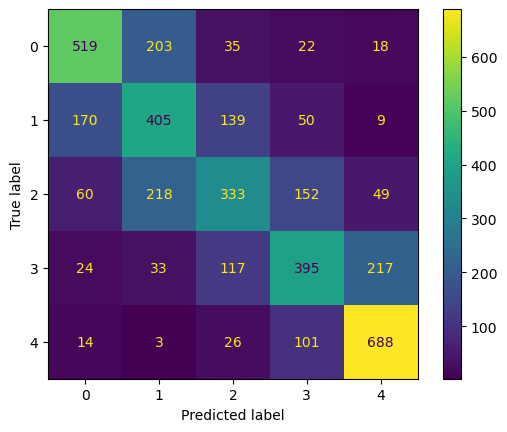

In [27]:
model.eval()
targs = []
preds = []

for batch in dataloader.test_dataloader():
    x, y = batch
    y_hat = model(x.to(device).float())
    pred = torch.argmax(y_hat, dim=1)
    targs.append(y.cpu().numpy())
    preds.append(pred.cpu().numpy())
    kappa_test.update(pred, y.to(device))

print("Test Kappa Score^2: %.2f" %kappa_test.compute())
cmd = ConfusionMatrixDisplay(confusion_matrix(y_true=np.concatenate(targs), y_pred=np.concatenate(preds)))
cmd.plot()
plt.show()

## CDW CE Loss

In [47]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = SimpleNN(input_dim=16, output_dim=5).to(device) ## 11 features, and 7 class
optim = torch.optim.RAdam(model.parameters(), lr=5e-3, weight_decay=1e-4)

loss_cdw = CDW_CELoss(num_classes=5,
                  transform="huber",
                  alpha=1.5).to(device)
loss = nn.CrossEntropyLoss().to(device)


kappa_train = MulticlassCohenKappa(num_classes=5, weights="quadratic").to(device)
kappa_test = MulticlassCohenKappa(num_classes=5, weights="quadratic").to(device)


NUM_EPOCHS = 20

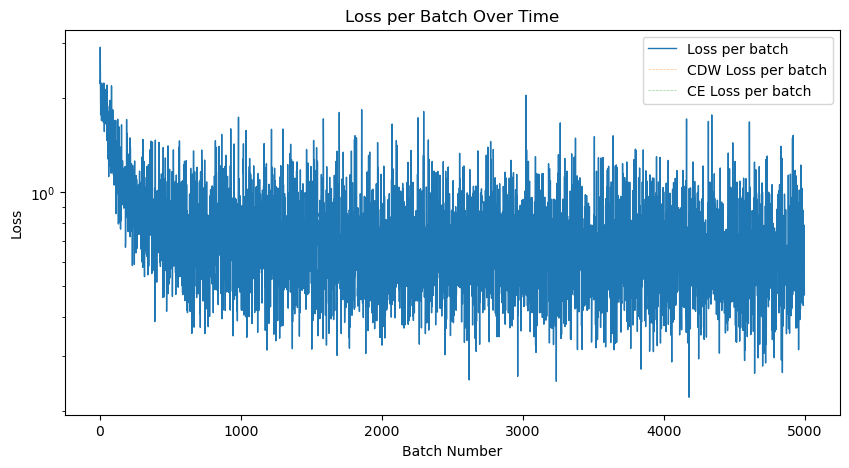

In [48]:
from IPython.display import clear_output

losses, losses_cdw, losses_ce = [], [], []

def plot_losses(losses, losses_cdw, losses_ce):
    clear_output(wait=True)  # Clear the previous plot
    plt.figure(figsize=(10,5))
    plt.plot(losses, label='Loss per batch', linewidth=1)
    plt.plot(losses_cdw, label='CDW Loss per batch', alpha=0.5, linewidth=0.5, linestyle='dashed')
    plt.plot(losses_ce, label='CE Loss per batch', alpha=0.5, linewidth=0.5, linestyle='dashed')

    plt.xlabel('Batch Number')
    plt.ylabel('Loss')
    plt.title('Loss per Batch Over Time')
    plt.yscale("log")
    plt.legend()
    plt.show()

for i in range(NUM_EPOCHS):
    for batch in dataloader.train_dataloader():
        x, y = batch
        y_hat = model(x.to(device).float())
        pred = torch.argmax(y_hat, dim=1)
        probs = F.softmax(y_hat, dim=1)
        kappa_train.update(pred, y.to(device))
        l_cdw = loss_cdw(probs, y.to(device))
        l_ce = loss(y_hat, y.to(device).long())
        l = l_cdw 
        kappa_train.update(pred, y.to(device).long())
        losses.append(l.item())
        l.backward()
        optim.step()
        optim.zero_grad()

    # Plotting at the end of each epoch
    plot_losses(losses, losses_cdw, losses_ce)

    if i % 5 == 0:
        print("Epoch %s: %.2f Kappa Score^2" % (i, kappa_train.compute()))


Test Kappa Score^2: 0.81


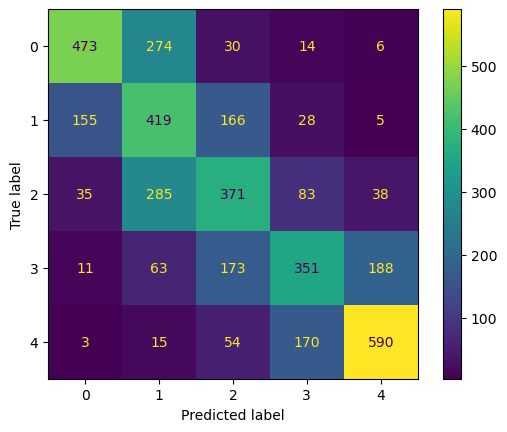

In [49]:
model.eval()
targs = []
preds = []
for batch in dataloader.test_dataloader():
    x, y = batch
    y_hat = model(x.to(device).float())
    pred = torch.argmax(y_hat, dim=1)
    targs.append(y.cpu().numpy())
    preds.append(pred.cpu().numpy())
    kappa_test.update(pred, y.to(device))
print("Test Kappa Score^2: %.2f" %kappa_test.compute())
cmd = ConfusionMatrixDisplay(confusion_matrix(y_true=np.concatenate(targs), y_pred=np.concatenate(preds)))
cmd.plot()
plt.show()